# Histopathologic Cancer Detection

In [113]:
import torch
from torch import nn
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from PIL import Image

import os
from pathlib import Path
import shutil
from tqdm.auto import tqdm

# Downloading Image Dataset

In a terminal, run the following command:

**Source:** https://www.kaggle.com/c/histopathologic-cancer-detection/data

```shell
kaggle competitions download -c histopathologic-cancer-detection
```

This downloads the `histopathologic-cancer-detection` dataset with `train` and `test` images in their respective directories. Each train image has an `image id` and a `label` specified in `train_labels.csv`.

File structure:

```txt
histopathologic-cancer-detection/
├── test/
│   └── img_1_test.tif
├── train/
│   └── img_1_train.tif
└── train_labels.csv

```

## Explore Dataset

In [3]:
DATA_DIR = Path.home() / 'Downloads' / 'histopathologic-cancer-detection'

TRAIN_DIR = DATA_DIR / 'train'
TEST_DIR = DATA_DIR / 'test'
LABELS_PATH = DATA_DIR / 'train_labels.csv'

In [4]:
def count_files(path, file_type: str) -> int:
    num_files = len(list(Path(path).glob(file_type)))
    return num_files

In [5]:
print(f'Number of Train Images: {count_files(TRAIN_DIR, "*.tif")}')
print(f'Number of Test Images: {count_files(TEST_DIR, "*.tif")}') 

Number of Train Images: 220025
Number of Test Images: 57458


### Examine Training Data

In [6]:
# get list of image file names
train_image_paths = list(Path(TRAIN_DIR).glob('*.tif'))

# observe the first 5 image names
print(f'Sample of Train Images:\n')
for i in train_image_paths[:5]:
    print(i.stem + i.suffix)

Sample of Train Images:

f0c2a0b8ef3024f407fa97d852d49be0215cafe0.tif
99ef485f205645918613cd04281098daa7c17819.tif
e2612e173abd0e8bb54a3c3db3f264b63d80bffb.tif
6d1bb57c0606f05dbd75f90a8d9e21a57e1267e0.tif
9c043ab2adadfeb758c71d21432fccd3e43565c0.tif


In [7]:
# observe train image labels
train_labels = pd.read_csv(DATA_DIR / 'train_labels.csv')

train_labels.head(5)

,id,label
0,f38a6374c348f90b587e046aac6079959adf3835,0
1,c18f2d887b7ae4f6742ee445113fa1aef383ed77,1
2,755db6279dae599ebb4d39a9123cce439965282d,0
3,bc3f0c64fb968ff4a8bd33af6971ecae77c75e08,0
4,068aba587a4950175d04c680d38943fd488d6a9d,0


### Training Class Balance

Label 0: 59.50 %
Label 1: 40.50 %


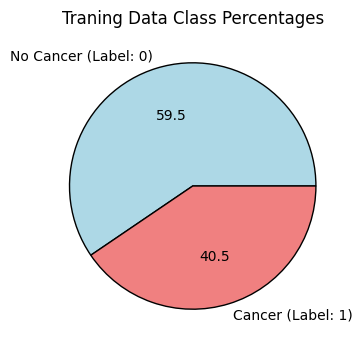

In [8]:
# examine training data's class balance
train_labels_counts = train_labels.label.value_counts()

print(f'Label 0: {train_labels_counts[0] / len(train_labels) * 100:.2f} %')
print(f'Label 1: {train_labels_counts[1] / len(train_labels) * 100:.2f} %')

plt.figure(figsize=(4, 4))
plt.pie(train_labels_counts,
        labels=['No Cancer (Label: 0)', 'Cancer (Label: 1)'],
        startangle=0, colors=['lightblue', 'lightcoral'],
        autopct='%1.1f',
        wedgeprops={'edgecolor': 'black',
                    'linewidth': 1})
plt.title('Traning Data Class Percentages')
plt.show()


### Observe Sample of Training Images

In [9]:
def view_sample_images(train_dir, file_type: str, train_labels_path, rows=2, n=16, cols=16//2, seed=4):
    # adjust random seed as you see fit
    np.random.seed(seed)

    train_image_paths = list(Path(train_dir).glob(f'*.{file_type}'))
    df_labels = pd.read_csv(train_labels_path)

    # get n random samples
    samples = np.random.choice(train_image_paths, n)
    print(len(samples))

    # display samples
    plt.figure(figsize=(14, 4))
    for i, img_path in enumerate(samples):
        with Image.open(img_path) as f:
            # get image label
            label = df_labels.loc[df_labels['id'] == img_path.stem, 'label'].values[0]

            plt.subplot(rows, cols, i+1)
            plt.imshow(f)
            plt.title(f'Label: {label}')
            plt.axis(False)

16


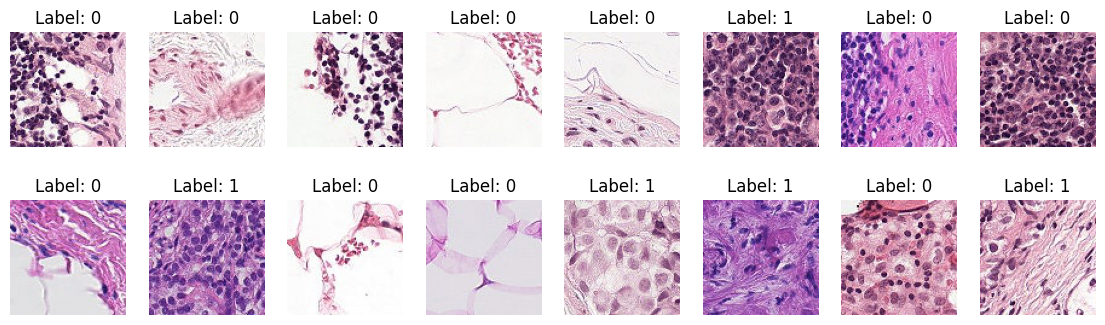

In [10]:
view_sample_images(TRAIN_DIR, 'tif', LABELS_PATH, seed=6)

# Data Preprocessing

The default dataset does not have available labels for images in `Test` directory. To have a test set with labels so that we can evaluate our model's performance on unseen data, we will partition a subset of the training data. Thus, the images in `Test` directory from the original download will not be used.

## Get Subset of Training Data

There are over 200,000 training images. The keep model training to a reasonable computational complexity due to hardware limitations, we'll get 10,000 samples.
- 6,000 samples of label 0
- 4,000 samples of label 1

In [11]:
def get_data_subset(train_dir, train_labels_path, file_type='*.tif', label_0=0.6, label_1=0.4, n_samples=10000, seed=4) -> list:
    """Gets a random subset of train image paths

    Returns:
        subset_paths (List)
    """
    # set random seed
    np.random.seed(seed)

    df_labels = pd.read_csv(train_labels_path)

    # get random samples of label 0
    n_samples_0 = int(label_0 * n_samples)
    df_0 = df_labels[df_labels.label == 0]
    samples_0 = df_0.sample(n=n_samples_0).reset_index(drop=True)

    # get random samples of label 1
    n_samples_1 = int(label_1 * n_samples)
    df_1 = df_labels[df_labels.label == 1]
    samples_1 = df_1.sample(n=n_samples_1).reset_index(drop=True)

    # get file paths of selected samples
    train_image_paths = list(Path(train_dir).glob(file_type))
    train_image_paths_stem = [i.stem for i in train_image_paths]

    # subset paths
    subset_paths = []
    for i in range(len(samples_0)):
        img_id = samples_0['id'][i]
        try:
            index = train_image_paths_stem.index(img_id)
            img_and_label = (train_image_paths[index], 0)
            subset_paths.append(img_and_label)
        except ValueError:
            print(f'img_id {img_id} not in train_image_paths_stem')
    
    for i in range(len(samples_1)):
        img_id = samples_1['id'][i]
        try:
            index = train_image_paths_stem.index(img_id)
            img_and_label = (train_image_paths[index], 1)
            subset_paths.append(img_and_label)
        except ValueError:
            print(f'img_id {img_id} not in train_image_paths_stem')
    
    return subset_paths

In [12]:
subset_paths = get_data_subset(TRAIN_DIR, LABELS_PATH)

# sanity check
print(len(subset_paths))

10000


In [13]:
subset_paths[:5]

[(PosixPath('/Users/akechi/Downloads/histopathologic-cancer-detection/train/6a14c163ddd26c16c571411b33275d06d2845798.tif'),
  0),
 (PosixPath('/Users/akechi/Downloads/histopathologic-cancer-detection/train/70e4ed537657ba450a76fc54840dd34e7d179fce.tif'),
  0),
 (PosixPath('/Users/akechi/Downloads/histopathologic-cancer-detection/train/067e95e28c0eac99689a10229dd14031e85e7f2a.tif'),
  0),
 (PosixPath('/Users/akechi/Downloads/histopathologic-cancer-detection/train/11f15c393aac3a649087d9739b20d11a3bb0141e.tif'),
  0),
 (PosixPath('/Users/akechi/Downloads/histopathologic-cancer-detection/train/c73ec32adbe0ee73edd09f587d559068c22f2252.tif'),
  0)]

## Move Image Files Into Standard Structure For Training

We will apply `torchvision.datasets.ImageFolder` onto our structured directories, and then using `torch.utils.data.Dataloader` to make data management easier during model training.

**Standard Directory Structure For CNN Data:**

```txt
Downloads/
└── working/
    ├── train/
    │   ├── 0/
    │   │   └── img1.tif
    │   └── 1/
    │       └── img2.tif
    └── test/
        ├── 0/
        │   └── img3.tif
        └── 1/
            └── img4.tif
```

`subset_paths` is a list of tuples, with 1st item being image path, and 2nd item the image's label, as shown:
- `[(path/to/img1, label), (path/to/img2, label), ...]`

### Spit Data

In [14]:
def split_paths_and_labels(subset_paths: list, test_size=0.25, random_state=4):
    """
    Splits the subset training paths into training and test sets

    Parameters:
        setset_paths (list): list of image paths
    
    Returns:
        X_train (list), X_test (list), y_train (list), y_test (list)
    """
    # unpack
    X, y = zip(*subset_paths)

    # train test split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state, stratify=y)

    return X_train, X_test, y_train, y_test

In [15]:
# split paths and labels
X_train, X_test, y_train, y_test = split_paths_and_labels(subset_paths, test_size=0.25)

In [16]:
# sanity check
print('Number of Samples:\n')

print(f'X: {len(X_train) + len(X_test)}')
print(f'y: {len(y_train) + len(y_test)}\n')

print(f'X_train: {len(X_train)}')
print(f'X_test: {len(X_test)}\n')
print(f'y_train: {len(y_train)}')
print(f'y_test: {len(y_test)}')

# observe
print(f'\nTrain sample: {X_train[0].stem, y_train[0]}')
print(f'Test sample: {X_test[0].stem, y_test[0]}')

Number of Samples:

X: 10000
y: 10000

X_train: 7500
X_test: 2500

y_train: 7500
y_test: 2500

Train sample: ('a7e019455df8d916d599f8f709f4c77457861ab0', 1)
Test sample: ('72022a21414fd3b8f2bd9b0897b99da411d75df9', 0)


### Copy Images to New Directory Structure

In [17]:
def make_working_directories(train_path, test_path) -> None:
    """
    Creates standard directory structure for image classification using CNNs

    Parameters:
        train_path: path to training directory
        test_path: path to test directory
    
    """
    # declare paths
    train_0 = train_path / '0'
    train_1 = train_path / '1'
    
    test_0 = test_path / '0'
    test_1 = test_path / '1'

    print(f'Creating working directories...')
    # create directories
    Path(train_0).mkdir(parents=True, exist_ok=True)
    Path(train_1).mkdir(parents=True, exist_ok=True)

    Path(test_0).mkdir(parents=True, exist_ok=True)
    Path(test_1).mkdir(parents=True, exist_ok=True)

    print(f'Working directories created successfully!')

In [18]:
len(set(X_train + X_test))

10000

In [19]:
def copy_files(train_path, test_path, X_train: list, y_train: list, X_test:list, y_test:list):

    # create working train & test directories
    make_working_directories(train_path=train_path, test_path=test_path)

    assert len(X_train) == len(y_train)
    assert len(X_test) == len(y_test)

    # copy over subset images to working directories
    # use tqdm to show progress
    print(f'Copying subset image samples...')
    
    total_iterations = len(X_train) + len(X_test)
    with tqdm(total=total_iterations) as pbar:
        for img, label in zip(X_train, y_train):
            if label == 0:
                shutil.copy(img, train_path / '0')
            if label == 1:
                shutil.copy(img, train_path / '1')
            pbar.update(1)
        
        for img, label in zip(X_test, y_test):
            if label == 0:
                shutil.copy(img, test_path / '0')
            if label == 1:
                shutil.copy(img, test_path / '1')
            pbar.update(1)
    
    print(f'Subset image samples copied successfully!')

In [20]:
# define target paths
WORKING_PATH = Path.home() / 'Downloads/working'

WORKING_TRAIN = WORKING_PATH / 'train'
WORKING_TEST = WORKING_PATH / 'test'

In [21]:
# copy subset image samples to working directories
copy_files(train_path=WORKING_TRAIN, test_path=WORKING_TEST, X_train=X_train, y_train=y_train, X_test=X_test, y_test=y_test)

Creating working directories...
Working directories created successfully!
Copying subset image samples...


  0%|          | 0/10000 [00:00<?, ?it/s]

Subset image samples copied successfully!


In [22]:
print(f'X_train, label 0: {len(list(Path(WORKING_TRAIN / "0").iterdir()))}')
print(f'X_train, label 1: {len(list(Path(WORKING_TRAIN / "1").iterdir()))}\n')

print(f'X_test, label 0: {len(list(Path(WORKING_TEST / "0").iterdir()))}')
print(f'X_test, label 1: {len(list(Path(WORKING_TEST / "1").iterdir()))}')

X_train, label 0: 4500
X_train, label 1: 3000

X_test, label 0: 1500
X_test, label 1: 1000


## Create DataLoader

1. create function to transform images to `torch.tensor` type
2. load images using `ImageFolder`
3. turn image data into `DataLoader` for batch training

The following function resizes the images from `96x96` to `64x64` to reduce memory size used for training. `transforms.RandomHorizontalFlip` introduces some data augmentation to introduce more variability in training data so that model can better generalize. Lastly, convert images to tensors so it can be fed into model.

In [23]:
# applies various transformations to training images
data_transform = transforms.Compose([
    transforms.Resize(size=(64, 64)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor()
])

In [84]:
# load the image data
train_data = datasets.ImageFolder(root=WORKING_TRAIN,
                                  transform=data_transform,
                                  target_transform=None)

test_data = datasets.ImageFolder(root=WORKING_TEST,
                                 transform=data_transform,
                                 target_transform=None)

# observe
#print(f'train_data 1st sample: {train_data.samples[0]}\n')

img, label = train_data[0][0], train_data[0][1]
print(f'Image tensor: {img}\n')
print(f'Image shape: {img.shape}')
print(f'Image dtype: {img.dtype}')
print(f'Label: {label}')
print(f'Label dtype: {type(label)}')

Image tensor: tensor([[[0.3294, 0.4549, 0.7216,  ..., 0.8706, 0.9216, 0.8784],
         [0.4000, 0.5137, 0.6235,  ..., 0.7804, 0.8627, 0.9137],
         [0.5059, 0.5961, 0.3608,  ..., 0.8745, 0.7922, 0.8118],
         ...,
         [0.9176, 0.7961, 0.6627,  ..., 0.8902, 0.8902, 0.8941],
         [0.6471, 0.6980, 0.6784,  ..., 0.8941, 0.8980, 0.9020],
         [0.7725, 0.7176, 0.6588,  ..., 0.9020, 0.9020, 0.9059]],

        [[0.1569, 0.2627, 0.5216,  ..., 0.4431, 0.4745, 0.4471],
         [0.2039, 0.2980, 0.4118,  ..., 0.3608, 0.4235, 0.4824],
         [0.2980, 0.3765, 0.1529,  ..., 0.4863, 0.3725, 0.4000],
         ...,
         [0.6745, 0.5412, 0.4275,  ..., 0.8667, 0.8706, 0.8627],
         [0.3804, 0.4314, 0.4157,  ..., 0.8667, 0.8667, 0.8627],
         [0.4863, 0.4353, 0.3686,  ..., 0.8627, 0.8627, 0.8588]],

        [[0.5804, 0.6196, 0.8392,  ..., 0.7804, 0.8314, 0.8000],
         [0.5843, 0.6471, 0.7412,  ..., 0.6941, 0.7647, 0.8157],
         [0.6314, 0.7176, 0.5098,  ..., 0.80

In [85]:
# create dataloader
BATCH_SIZE = 32

train_dataloader = DataLoader(dataset=train_data,
                              batch_size=BATCH_SIZE,
                              shuffle=True)

test_dataloader = DataLoader(dataset=test_data,
                             batch_size=BATCH_SIZE,
                             shuffle=True)

Let's observe the number of batches in each dataloader:

In [88]:
print(f'training batches: {len(train_dataloader)}')
print(f'testing batches: {len(test_dataloader)}')

training batches: 235
testing batches: 79


To further verify, we can confirm the total of 32 images per batch to roughly equal 10,000 images due to uneven division: 10000 / 32

In [89]:
print(f'~ total images: {32 * (235 + 79)}')

~ total images: 10048


In [107]:
imgs, labels = next(iter(train_dataloader))

print(f'sample image tensor:\n{imgs[0]}')
print(f'sample image shape: {imgs[0].shape}')
print(f'sample image label: {labels[0]}\n')

print(f'image batch shape: {imgs.shape}')
print(f'labels batch shape: {labels.shape}')

sample image tensor:
tensor([[[0.8471, 0.8667, 0.9098,  ..., 0.4000, 0.4314, 0.4980],
         [0.8980, 0.9137, 0.9490,  ..., 0.4039, 0.3608, 0.4078],
         [0.9059, 0.8549, 0.8549,  ..., 0.4431, 0.3176, 0.3529],
         ...,
         [0.5137, 0.4314, 0.5216,  ..., 0.2784, 0.3059, 0.6824],
         [0.6863, 0.6275, 0.5843,  ..., 0.3647, 0.4000, 0.8039],
         [0.8706, 0.7216, 0.5569,  ..., 0.6118, 0.7608, 0.9490]],

        [[0.7373, 0.7333, 0.7412,  ..., 0.2510, 0.2706, 0.3294],
         [0.7765, 0.7843, 0.7922,  ..., 0.2627, 0.2118, 0.2588],
         [0.7608, 0.7216, 0.6902,  ..., 0.2980, 0.1804, 0.2196],
         ...,
         [0.4078, 0.3176, 0.3882,  ..., 0.1451, 0.1647, 0.5373],
         [0.5608, 0.4863, 0.4314,  ..., 0.2784, 0.2980, 0.7020],
         [0.7137, 0.5490, 0.3765,  ..., 0.5451, 0.6784, 0.8667]],

        [[0.8353, 0.8118, 0.7961,  ..., 0.4235, 0.4196, 0.4588],
         [0.8353, 0.8353, 0.8549,  ..., 0.4392, 0.3922, 0.4392],
         [0.8118, 0.7765, 0.7686,  ..

# Create Model

## Baseline Model

In [109]:
class SimpleModel(nn.Module):
    """
    Use a simple model with 3 convolutional layers
    """
    def __init__(self, input_shape: int, hidden_units: int, output_shape: int):
        super().__init__()
        self.conv_block_1 = nn.Sequential(
            nn.Conv2d(in_channels=input_shape,
                      out_channels=hidden_units,
                      kernel_size=3,
                      stride=1,
                      padding=0
                      ),
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units,
                      out_channels=hidden_units,
                      kernel_size=3,
                      stride=1,
                      padding=0),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2,
                         stride=2)
        )
        self.conv_block_2 = nn.Sequential(
            nn.Conv2d(in_channels=hidden_units,
                      out_channels=hidden_units,
                      kernel_size=3,
                      stride=1,
                      padding=0
                      ),
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units,
                      out_channels=hidden_units,
                      kernel_size=3,
                      stride=1,
                      padding=0),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2,
                         stride=2)
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=hidden_units,
                      out_features=output_shape)
        )
    
    def forward(self, x):
        x = self.conv_block_1(x)
        #print(x.shape)
        x = self.conv_block_2(x)
        #print(x.shape)
        x = self.classifier(x)
        #print(x.shape)
        return x

In [115]:
torch.manual_seed(4)
torch.cuda.manual_seed(4)

base_model = SimpleModel(input_shape=3,
                         hidden_units=10,
                         output_shape=2)

In [117]:
base_model

SimpleModel(
  (conv_block_1): Sequential(
    (0): Conv2d(3, 10, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block_2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=10, out_features=2, bias=True)
  )
)

In [119]:
img_batch, label_batch = next(iter(train_dataloader))
print(img_batch.shape)
print(label_batch.shape)

torch.Size([32, 3, 64, 64])
torch.Size([32])


In [120]:
# forward pass
base_model(img_batch)

RuntimeError: mat1 and mat2 shapes cannot be multiplied (32x1690 and 10x2)

## Transfer Learning: Utilize Pre-trained Model

In [112]:
device = 'cuda' if is_available() else 'cpu'
device

'cpu'

In [ ]:
torch